In [1]:
import sys

if "../src" not in sys.path:
    sys.path.insert(0, "../src")

In [2]:
import os
import json
import copy
import pprint
import ast
import re
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display

import torch

from utils import read_json_file

In [4]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     /cephyr/users/mehrdadf/Alvis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
from experiments.utils import load_atlas
from experiments.tools import predict_token

/mimer/NOBACKUP/groups/snic2022-22-1003/APP/rag-memory-interplay/venv/lib/python3.9/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [1]:
os.environ["WANDB_CACHE_DIR"] = f"../../caches/wandb"
os.environ["TRANSFORMERS_CACHE"]= f"../../.cache/huggingface/transformers"
os.environ["HF_DATASETS_CACHE"] = f"../../.cache/huggingface/datasets"

SIZE = "base"  # "base", "large"
QA_PROMPT_FORMAT = "question: {question} answer: <extra_id_0>"

reader_model_type = f"google/t5-{SIZE}-lm-adapt"
model_path = f"../data/atlas/models/atlas_nq/{SIZE}"
model, opt = load_atlas(reader_model_type, model_path, n_context=1, qa_prompt_format="question: {question} answer: <extra_id_0>")
type(model)


NameError: name 'load_atlas' is not defined

In [7]:
# P170 => Who was [E] created by?
# P112 => Who founded [E]?
# P276 => Where is [E] located?
# P106 => What kind of work does [E] do?
# P131 => Where is [E] located?
# P495 => Which country was [E] created in?
# P175 => Who performed [E]?
# P127 => Who owns [E]?
# P159 => Where is the headquarter of [E]?
# P26 => Who is [E] married to?
# P413 => What position does [E] play?
# P800 => What is [E] famous for?
# P136 => What type of music does [E] play?
# P740 => Where was [E] founded?
# P407 => Which language was [E] written in?
# P50 => Who is the author of [E]?
# P19 => Where was [E] born?
# P20 => Where did [E] die?
# P17 => Which country is [E] located in?
# P69 => Where was [E] educated?
# P176 => Which company is [E] produced by?
# P40 => Who is [E]'s child?
# P264 => What music label is [E] represented by?
# P36 => What is the capital of [E]?

In [8]:
context_templates = {
    "P106": "{subj} is employed as a {obj} according to structured data.",
    "P19": "According to records, {subj} was born in {obj}.",
    "P17": "{subj} is located in the country of {obj}.",
    "P36": "According to records, the capital of {subj} is {obj}.",
    "P50": "According to records, {obj} authored {subj}.",
    "P175": "{obj} performed the song {subj}.",
    "P264": "{subj} is represented by the music label {obj}.",
    "P131": "{subj} is located in {obj}.",
    "P495": "{subj} was created in {obj}.",
    "P276": "The {subj} took place in {obj}.",
    "P40": "{obj} is the child of {subj}.",
    "P159": "The headquarters of {subj} is located in {obj}.",
    "P176": "The {subj} is produced by the company {obj}.",
    "P26": "{subj} is married to {obj}.",
    "P127": "{subj} is owned by {obj}.",
    "P69": "{subj} received their education at {obj}.",
    "P740": "{subj} was founded in {obj}.",
    "P20": "{subj} passed away in {obj}.",
    "P112": "{obj} founded the {subj}.",
    "P407": "{subj} was written in the {obj} language.",
    "P170": "{obj} is credited with creating {subj}.",
    "P800": "{subj} is renowned for {obj}.",
    "P413": "{subj} plays in the position of {obj}."
}

In [9]:
rows = (
    read_json_file("../data/atlas/peq_data/dev.jsonl", jsonl=True)
    +
    read_json_file("../data/atlas/peq_data/test.jsonl", jsonl=True)
)
data = []

for row in rows:
    data.append({
        "question": row["question"],
        "answers": [row["triplet"]["obj"]],
        "query": f"question: {row['question']} answer: <extra_id_0>",
        "subj": row["triplet"]["subj"],
        "prop": row["triplet"]["prop"],
        "prop": row["triplet"]["prop_code"],
        "obj": row["triplet"]["obj"],
        "metadata": [],
        "passages": [{"title": "", "text": context_templates.get(row["triplet"]["prop_code"], "").format(subj=row["triplet"]["subj"], obj=row["triplet"]["obj"])}] 
        if context_templates.get(row["triplet"]["prop_code"], None) else None
    })

    # break

df = pd.DataFrame(data)
print(f"We have #{len(df)} data")
df = df.dropna()
df = df.drop_duplicates(subset=["query", "subj", "obj"], keep="first").reset_index(drop=True)
print(f"We have #{len(df)} data")
df.head(2)

We have #44143 data
We have #42125 data


,question,answers,query,subj,prop,obj,metadata,passages
0,Where was Michael Jack born?,[Folkestone],question: Where was Michael Jack born? answer:...,Michael Jack,P19,Folkestone,[],"[{'title': '', 'text': 'According to records, ..."
1,Where was Vitaly Samoshko born?,[Kharkiv],question: Where was Vitaly Samoshko born? answ...,Vitaly Samoshko,P19,Kharkiv,[],"[{'title': '', 'text': 'According to records, ..."


In [10]:
df.iloc[0].to_dict()

{'question': 'Where was Michael Jack born?',
 'answers': ['Folkestone'],
 'query': 'question: Where was Michael Jack born? answer: <extra_id_0>',
 'subj': 'Michael Jack',
 'prop': 'P19',
 'obj': 'Folkestone',
 'metadata': [],
 'passages': [{'title': '',
   'text': 'According to records, Michael Jack was born in Folkestone.'}]}

In [11]:
subj_df = pd.DataFrame([{"subj": row["subj"], "prop": row["prop"], "tokens": model.reader_tokenizer.tokenize(row["subj"]), "len": len(model.reader_tokenizer.tokenize(row["subj"]))} for i, row in df.iterrows()])
subj_df = subj_df.drop_duplicates(subset=["subj", "prop"])
subj_df = subj_df.reset_index(drop=True)
subj_df.head()

,subj,prop,tokens,len
0,Michael Jack,P19,"[▁Michael, ▁Jack]",2
1,Vitaly Samoshko,P19,"[▁Vital, y, ▁Sam, o, s, h, k, o]",8
2,Dezső Ránki,P19,"[▁De, z, s, ő, ▁R, án, ki]",7
3,Clemens Busch,P19,"[▁C, le, men, s, ▁Bus, ch]",6
4,Emil Fackenheim,P19,"[▁Emil, ▁Fa, cken, heim]",4


In [12]:
obj_df = pd.DataFrame([{"obj": row["obj"], "prop": row["prop"], "tokens": model.reader_tokenizer.tokenize(row["obj"]), "len": len(model.reader_tokenizer.tokenize(row["obj"]))} for i, row in df.iterrows()])
obj_df = obj_df.drop_duplicates(subset=["obj", "prop"])
obj_df = obj_df.reset_index(drop=True)
obj_df.head()

,obj,prop,tokens,len
0,Folkestone,P19,"[▁Folk, e, stone]",3
1,Kharkiv,P19,"[▁Kha, r, ki, v]",4
2,Budapest,P19,[▁Budapest],1
3,Cologne,P19,"[▁C, ologne]",2
4,Halle (Saale),P19,"[▁Hall, e, ▁(, S, a, a, le, )]",8


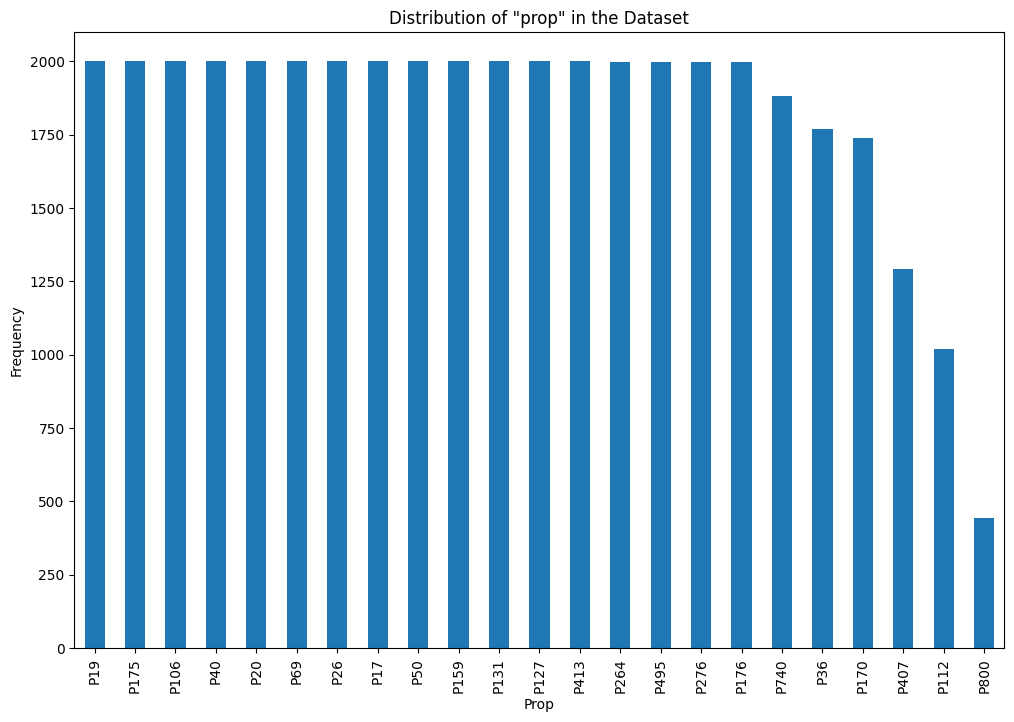

In [13]:
prop_counts = df['prop'].value_counts()
plt.figure(figsize=(12, 8)) 
prop_counts.plot(kind='bar')
plt.title('Distribution of "prop" in the Dataset')
plt.xlabel('Prop')
plt.ylabel('Frequency')
plt.xticks(rotation=90)  # Rotates the x-axis labels for better readability
plt.show()

In [14]:
prop_counts.sum()
# 41575

42125

In [15]:
def filter_attribute_same_domain(df, row, model, attribute="subj", k=10, random_state=101):
    """Filters attribute based on specific criteria."""
    # Combine conditions to filter df in one step
    conditions = (
        (df[attribute] != row[attribute]) &
        (df["prop"] == row["prop"]) &
        (df["len"].apply(lambda x: x == len(model.reader_tokenizer.tokenize(row[attribute]))))
    )

    filtered_df = df[conditions]

    if not filtered_df.empty:
        sampled_df = filtered_df.sample(n=min(k, len(filtered_df)), random_state=random_state)
        return sampled_df[attribute].tolist()
    else:
        return []

def filter_attribute_diff_domain(df, row, model, attribute="subj", k=10, random_state=101):
    """Filters attribute based on specific criteria. """
    # Combine conditions to filter df in one step
    conditions = (
        (df[attribute] != row[attribute]) &
        (df["prop"] != row["prop"]) &
        (df["len"].apply(lambda x: x == len(model.reader_tokenizer.tokenize(row[attribute]))))
    )

    filtered_df = df[conditions]

    if not filtered_df.empty:
        sampled_df = filtered_df.sample(n=min(k, len(filtered_df)), random_state=random_state)
        return sampled_df[attribute].tolist()
    else:
        return []

In [16]:
def generated_is_matched(answer, generated):
    return generated and (answer == generated or generated in answer or answer in generated)


def batchify(lst, batch_size):
    for i in range(0, len(lst), batch_size):
        yield lst[i:i + batch_size]


def attribute_status(text, attr1, attr2):
    status = [False, False]
    if attr1 in text:
        _text = copy.deepcopy(text)
        _text = re.sub(fr'\b{re.escape(attr1)}\b', f"[{attr1.upper()}_REPLACED]", _text)
        
        status[0] = True
        if attr2 in _text:
            status[1] = True
        else:
            status[1] = False
    else:
        status = [False, False]

    return all(status)

def pick_the_candidates(df, batch_size=5):
    data = []
    for i, row in tqdm(df.iterrows(), total=len(df)):
        query = row["query"]
        answers = row["answers"]

        question = row["question"]
        subj = row["subj"]
        prop = row["prop"]
        obj = row["obj"]


        subj_cf_same_domain = filter_attribute_same_domain(subj_df, row, model, attribute="subj")
        obj_cf_same_domain = filter_attribute_same_domain(obj_df, row, model, attribute="obj")

        subj_cf_diff_domain = filter_attribute_diff_domain(subj_df, row, model, attribute="subj")
        obj_cf_diff_domain = filter_attribute_diff_domain(obj_df, row, model, attribute="obj")

        if not len(subj_cf_same_domain) > 1 or not len(obj_cf_same_domain) > 1:
            continue


        p = row["passages"][0]
        subj_status = attribute_status(p["text"], subj, obj)
        obj_status = attribute_status(p["text"], obj, subj)

        if not subj_status or not obj_status:
            continue

        prompts_nocontext = [{"query": query, "passages": [{"title": "", "text": ""}], "answers": answers}]
        prompt_split = len(prompts_nocontext)
        prompts_context = [{"query": query, "passages": [{"title": " ", "text": p["text"]}], "answers": answers}]

        g = predict_token(model, prompts_nocontext + prompts_context, n_context=1).predicted_text
        for i in range(prompt_split):
            gen_nocontext_matched = generated_is_matched(answers[0], g[i])
            gen_context_matched = generated_is_matched(answers[0], g[i + prompt_split])

            data.append({
                "question": question,
                "answers": answers,
                "passages": [p],
                "subj": subj,
                "prop": prop,
                "obj": obj,
                "query": query,
                "gen_nocontext": g[i],
                "gen_context": g[i + prompt_split],
                "gen_nocontext_matched": gen_nocontext_matched,
                "gen_context_matched": gen_context_matched,
                "matched": gen_nocontext_matched and gen_context_matched,
                # "prop_cf": [context_templates[cf].format(subj=subj, obj=obj) for cf in relation_counterfactuals[prop]],
                "prop_cf": [],
                "subj_cf": subj_cf_same_domain,
                "obj_cf": obj_cf_same_domain,
                "subj_cf_diff": subj_cf_diff_domain,
                "obj_cf_diff": obj_cf_diff_domain,
            })
            
            break

        break
    
    return pd.DataFrame(data)

In [17]:
print(f"Number of data: {len(df)}")
matched_df = pick_the_candidates(df)
print(f"Number of data: {len(matched_df)}")
matched_df.head()

Number of data: 42125


  0%|          | 0/42125 [00:00<?, ?it/s]/mimer/NOBACKUP/groups/snic2022-22-1003/APP/rag-memory-interplay/venv/lib/python3.9/site-packages/transformers/modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/mimer/NOBACKUP/groups/snic2022-22-1003/APP/rag-memory-interplay/venv/lib/python3.9/site-packages/transformers/modeling_utils.py:1080: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
  0%|          | 0/42125 [00:05<?, ?it/s]

Number of data: 1


,question,answers,passages,subj,prop,obj,query,gen_nocontext,gen_context,gen_nocontext_matched,gen_context_matched,matched,prop_cf,subj_cf,obj_cf,subj_cf_diff,obj_cf_diff
0,Where was Michael Jack born?,[Folkestone],"[{'title': '', 'text': 'According to records, ...",Michael Jack,P19,Folkestone,question: Where was Michael Jack born? answer:...,"New York City, NY",Folkestone,False,True,False,[],"[Money Johnson, Bob Rush, Jeff Powell, Greg Da...","[Arcachon, Tampere, Velletri, Tavistock, Watfo...","[Sometimes?, Brandon Barnes, Beautiful Tonight...","[Fisz, The Feeling, Asian Man Records, Jessica..."


In [18]:
def save_data(df, save_dir, kind, groupby="prop"):
    save_dir = f"{save_dir}-{kind}"
    os.makedirs(save_dir, exist_ok=True)
    with open(f"{save_dir}-data.jsonl", "w", encoding="utf-8") as fj:
        for index, row in df.iterrows():
            fj.write(json.dumps(row.to_dict()) + "\n")

    props = df[groupby].unique()
    for prop in props:
        prop_code = prop.replace(" ", '_')
        prop_df = df[df[groupby] == prop]

        with open(f"{save_dir}/{prop_code}.jsonl", "w", encoding="utf-8") as fj:
            for index, row in prop_df.iterrows():
                fj.write(json.dumps(row.to_dict()) + "\n")

In [19]:
SAVE_DIR = "../data/syn/peq/data/matched"
SAVE_DIR

'../data/syn/peq/data/matched'

In [20]:
save_data(matched_df, SAVE_DIR, "all")


df_both = matched_df[matched_df["matched"] == True]
print(f"Collected {len(df_both)}/{len(matched_df)}")
save_data(df_both, SAVE_DIR, "both")

df_both_first = matched_df[matched_df["matched"] == True].groupby('question').first().reset_index()
print(f"Collected {len(df_both_first)}/{len(matched_df)}")
save_data(df_both_first, SAVE_DIR, "both-first")

df_gen_nocontext = matched_df[matched_df["gen_nocontext_matched"] == True]
print(f"Collected {len(df_gen_nocontext)}/{len(matched_df)}")
save_data(df_gen_nocontext, SAVE_DIR, "gen-nocontext")

df_gen_context = matched_df[matched_df["gen_context_matched"] == True]
print(f"Collected {len(df_gen_context)}/{len(matched_df)}")
save_data(df_gen_context, SAVE_DIR, "gen-context")

Collected 0/1
Collected 0/1
Collected 0/1
Collected 1/1
